# Assignment A3-GAN by ShiKai@20xxxxxx

**November 28, 2024**

## 模型原理

### GAN（生成对抗网络）
GAN 由一个生成器（Generator）和一个判别器（Discriminator）组成。生成器试图生成逼真的图像，而判别器试图区分真实图像和生成图像。两者通过对抗训练，生成器不断提高生成图像的质量，判别器不断提高区分能力。

### CGAN（条件生成对抗网络）
CGAN 是在 GAN 的基础上增加了条件输入。生成器和判别器都接收额外的条件信息（如类别标签），以生成特定类别的图像。这样可以控制生成图像的类别，提高生成图像的多样性和质量。

## 实验设置

### 数据集
使用 CIFAR-10 数据集，该数据集包含10个类别的60000张32x32彩色图像，其中50000张用于训练，10000张用于测试。

### 模型架构
- **生成器（GAN）**：输入为随机噪声，输出为生成的图像。
- **判别器（GAN）**：输入为图像，输出为图像的真实性概率。
- **生成器（CGAN）**：输入为随机噪声和类别标签，输出为生成的图像。
- **判别器（CGAN）**：输入为图像和类别标签，输出为图像的真实性概率。

### 训练参数
- 批量大小：128
- 学习率：0.0002
- 优化器：Adam（beta1=0.5, beta2=0.999）
- 训练轮数：GAN为10轮，CGAN为20轮

## 实验结果分析

### 损失图
在训练过程中，记录生成器和判别器的损失值。以下是GAN和CGAN的损失图：

#### GAN 损失图
![GAN Loss](/home/shikai/large/repos/Advanced-Machine-Learning/exper_a3/images/GAN_loss.png)

#### CGAN 损失图
![CGAN Loss](/home/shikai/large/repos/Advanced-Machine-Learning/exper_a3/images/CGAN_loss.png)

### 生成图像的例子
以下是GAN和CGAN生成的图像示例：

#### GAN 生成的图像
![GAN Samples](/home/shikai/large/repos/Advanced-Machine-Learning/exper_a3/images/gan_samples.png)

#### CGAN 生成的图像
![CGAN Samples](/home/shikai/large/repos/Advanced-Machine-Learning/exper_a3/images/cgan_samples.png)

### 结果分析
从生成图像的质量来看，CGAN生成的图像在类别一致性和多样性方面优于 GAN。这是因为 CGAN 利用了类别标签信息，使得生成器能够生成特定类别的图像。此外，CGAN 的损失曲线更为平稳，表明其训练过程更加稳定。

# 定义一个图像生成问题

## 问题定义
设计一个生成模型，用于生成高分辨率的医学影像（如MRI或CT扫描图像），以辅助医生进行疾病诊断和研究。生成的图像应具有高质量和高分辨率，并且能够反映不同病变的特征。

## 调研现有方法和策略
### 现有方法
- **GAN**：生成对抗网络（GAN）在图像生成领域取得了显著的成果，但在生成高分辨率图像时可能会遇到训练不稳定和模式崩溃的问题。
- **CGAN**：条件生成对抗网络（CGAN）通过引入条件信息（如类别标签）提高了生成图像的多样性和质量，但在医学影像生成中，类别标签可能不足以描述复杂的病变特征。
- **StyleGAN**：StyleGAN通过引入风格向量和渐进式生成功能，能够生成高分辨率和高质量的图像，但其训练过程复杂且计算资源需求高。
- **VAE**：变分自编码器（VAE）通过学习潜在空间分布生成图像，但生成图像的质量和分辨率通常不如GAN。

### 现有策略
- **多尺度生成**：通过多尺度生成器和判别器，提高生成图像的分辨率和细节。
- **渐进式生成**：逐步增加生成图像的分辨率，减少训练不稳定性。
- **条件生成**：引入更多的条件信息（如病变区域、病变类型等），提高生成图像的多样性和质量。
- **对抗训练**：通过对抗训练，提高生成图像的真实性和细节。

## 设计解决方案
### 模型架构
设计一个多尺度条件生成对抗网络（MSC-GAN），结合多尺度生成、渐进式生成和条件生成的策略，以生成高分辨率的医学影像。

#### 生成器
- **多尺度生成**：生成器由多个子生成器组成，每个子生成器生成不同尺度的图像，并逐步融合生成高分辨率图像。
- **条件输入**：生成器接收病变区域、病变类型等条件信息，以生成特定病变的图像。

#### 判别器
- **多尺度判别**：判别器由多个子判别器组成，每个子判别器对不同尺度的图像进行判别，提高判别的准确性和细节。

### 训练策略
- **渐进式生成**：逐步增加生成图像的分辨率，从低分辨率开始，逐步增加到高分辨率，减少训练不稳定性。
- **对抗训练**：通过对抗训练，提高生成图像的真实性和细节。
- **条件生成**：引入病变区域、病变类型等条件信息，提高生成图像的多样性和质量。

## 方法的可行性和创新性
### 可行性
- **多尺度生成和判别**：多尺度生成和判别策略已经在图像生成领域取得了成功，能够提高生成图像的分辨率和细节。
- **渐进式生成**：渐进式生成策略能够减少训练不稳定性，提高生成图像的质量。
- **条件生成**：引入病变区域、病变类型等条件信息，能够提高生成图像的多样性和质量，满足医学影像生成的需求。

### 创新性
- **多尺度条件生成对抗网络（MSC-GAN）**：结合多尺度生成、渐进式生成和条件生成的策略，设计一个新的生成模型，以生成高分辨率的医学影像。
- **条件输入**：引入病变区域、病变类型等条件信息，提高生成图像的多样性和质量，满足医学影像生成的需求。
- **多尺度判别**：通过多尺度判别策略，提高判别的准确性和细节，增强生成图像的真实性。

## 总结
通过设计多尺度条件生成对抗网络（MSC-GAN），结合多尺度生成、渐进式生成和条件生成的策略，能够生成高分辨率和高质量的医学影像，辅助医生进行疾病诊断和研究。该方法具有较高的可行性和创新性，能够满足医学影像生成的需求。

# 代码实现

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [79]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 标准化
])

# 加载 CIFAR-10 数据集
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=96, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=96, pin_memory=True)

# use GPU if available
for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    break
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    break

Files already downloaded and verified
Files already downloaded and verified


## GAN 网络的生成器和判别器的实现

In [80]:
# 生成器 （GAN）
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [81]:
# 判别器 (GAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# 初始化模型
latent_dim = 128
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
epochs = 20

In [88]:
# 加载预训练的GAN
generator.load_state_dict(torch.load('generator.pth', map_location=device, weights_only=False))
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 4, 4))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Tanh()
  )
)

In [118]:
_d_loss = []
_g_loss = []
# 训练
for epoch in range(epochs):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)  # 将真实图像转移到 GPU
        
        # 训练判别器
        valid = torch.ones(real_imgs.size(0), 1, device=device)  # 正样本标签
        fake = torch.zeros(real_imgs.size(0), 1, device=device)  # 负样本标签

        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)  # 随机噪声
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 训练生成器
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

    _d_loss.append(d_loss.item())
    _g_loss.append(g_loss.item())
    print(f"Epoch {epoch+1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
    

# save model
torch.save(generator.state_dict(), 'generator.pth')


Epoch 1, D Loss: 0.8098704218864441, G Loss: 1.8619928359985352
Epoch 2, D Loss: 0.8143492937088013, G Loss: 1.9492089748382568
Epoch 3, D Loss: 0.8761733770370483, G Loss: 2.950330972671509
Epoch 4, D Loss: 0.48808902502059937, G Loss: 2.676682949066162
Epoch 5, D Loss: 1.1519684791564941, G Loss: 1.1380131244659424
Epoch 6, D Loss: 0.7390499114990234, G Loss: 2.168138027191162
Epoch 7, D Loss: 0.8000754117965698, G Loss: 1.9347649812698364
Epoch 8, D Loss: 0.6719695329666138, G Loss: 2.3198981285095215
Epoch 9, D Loss: 0.8837672472000122, G Loss: 1.684767723083496
Epoch 10, D Loss: 1.372956395149231, G Loss: 1.7767586708068848
Epoch 11, D Loss: 0.9817608594894409, G Loss: 1.3654119968414307
Epoch 12, D Loss: 1.0450713634490967, G Loss: 2.0001540184020996
Epoch 13, D Loss: 0.9445137977600098, G Loss: 1.6755491495132446
Epoch 14, D Loss: 1.5429491996765137, G Loss: 1.3883700370788574
Epoch 15, D Loss: 1.1885986328125, G Loss: 1.537800669670105
Epoch 16, D Loss: 1.047600507736206, G Los

Accuracy: 59.81570512820513%


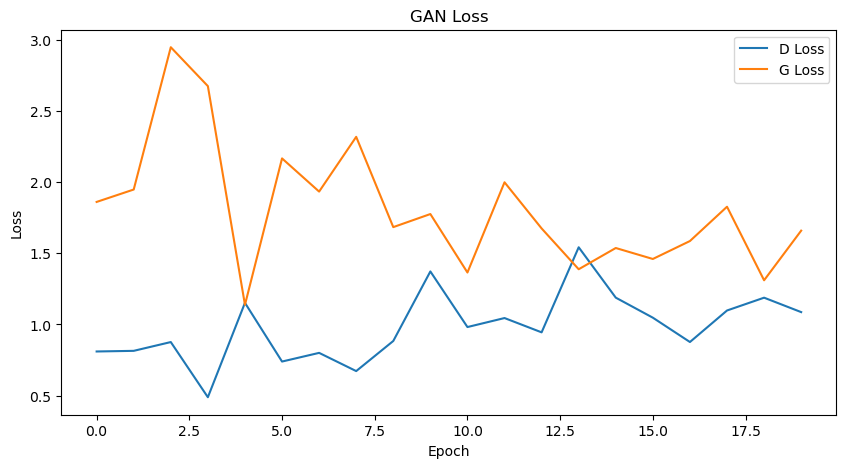

In [135]:
correct = 0
total = 0
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        outputs = discriminator(imgs)
        predicted = (outputs > 0.5).float()
        total += imgs.size(0)
        correct += (predicted == torch.ones_like(predicted, device=device)).sum().item()
print(f"Accuracy: {100 * correct / total}%")

# plot loss (_d_loss, _g_loss)
plt.figure(figsize=(10, 5))
plt.title('GAN Loss')
plt.plot(_d_loss, label='D Loss')
plt.plot(_g_loss, label='G Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./images/GAN_loss.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


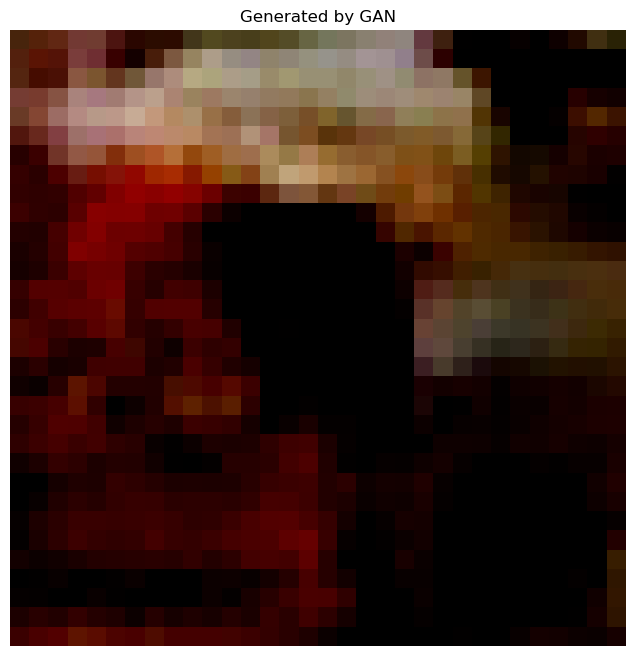

In [129]:
# 保存生成图像 （GAN）
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)  # 噪声在 GPU 上
    samples = generator(z).cpu()  # 将生成的样本转移到 CPU
    save_image(samples, './images/gan_samples.png', nrow=8)
    
    # show img
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated by GAN")
    plt.imshow(np.transpose(samples[0], (1, 2, 0)))
    plt.show()

## 下面的部分是 CGAN 条件生成网络的实现

In [92]:
# 生成器 （CGAN）
class CGenerator(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10):
        super(CGenerator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embeds = self.label_embedding(labels)
        input = torch.cat([z, label_embeds], dim=1)
        return self.model(input)

In [93]:
# 判别器 (CGAN)
class CDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(CDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, 32 * 32)
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # 输入通道变为 3+1=4
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_embeds = self.label_embedding(labels).view(labels.size(0), 1, 32, 32)  # 嵌入标签并调整维度
        input = torch.cat([x, label_embeds], dim=1)  # 拼接图像和标签
        return self.model(input)

In [105]:
# 初始化模型 (CGAN)
latent_dim = 128
num_classes = 10
c_generator = CGenerator(latent_dim, num_classes).to(device)
c_discriminator = CDiscriminator(num_classes).to(device)

c_optimizer_G = optim.Adam(c_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
c_optimizer_D = optim.Adam(c_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
c_criterion = nn.BCELoss()
epochs = 20

In [95]:
# 加载预训练的GAN
c_generator.load_state_dict(torch.load('c_generator.pth', map_location=device, weights_only=False))
c_generator.eval()

CGenerator(
  (label_embedding): Embedding(10, 128)
  (model): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 4, 4))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Tanh()
  )
)

In [116]:
# CGAN 训练
c_d_loss = []
c_g_loss = []
for epoch in range(epochs):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        
        # 判别器训练
        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)
        
        c_optimizer_D.zero_grad()
        real_loss = c_criterion(c_discriminator(real_imgs, labels), valid)
        
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_labels = torch.randint(0, 10, (real_imgs.size(0),), device=device)
        fake_imgs = c_generator(z, gen_labels)
        fake_loss = c_criterion(c_discriminator(fake_imgs.detach(), gen_labels), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        c_optimizer_D.step()
        
        # 生成器训练
        c_optimizer_G.zero_grad()
        g_loss = c_criterion(c_discriminator(fake_imgs, gen_labels), valid)
        g_loss.backward()
        c_optimizer_G.step()
    
    c_d_loss.append(d_loss.item())
    c_g_loss.append(g_loss.item())
    print(f"Epoch {epoch+1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# save model
torch.save(c_generator.state_dict(), 'c_generator.pth')    

Epoch 1, D Loss: 0.8743623495101929, G Loss: 2.259223222732544
Epoch 2, D Loss: 0.8155656456947327, G Loss: 1.769676685333252
Epoch 3, D Loss: 0.8506515026092529, G Loss: 1.826546311378479
Epoch 4, D Loss: 0.7407988905906677, G Loss: 1.5945104360580444
Epoch 5, D Loss: 1.1303911209106445, G Loss: 1.490159034729004
Epoch 6, D Loss: 0.7701925039291382, G Loss: 1.6992360353469849
Epoch 7, D Loss: 0.696530818939209, G Loss: 1.9795485734939575
Epoch 8, D Loss: 0.7118475437164307, G Loss: 1.6620806455612183
Epoch 9, D Loss: 1.169431209564209, G Loss: 1.6172832250595093
Epoch 10, D Loss: 0.8436033725738525, G Loss: 2.0008249282836914
Epoch 11, D Loss: 0.4970109462738037, G Loss: 2.3542604446411133
Epoch 12, D Loss: 1.5365229845046997, G Loss: 3.1807332038879395
Epoch 13, D Loss: 0.7098692059516907, G Loss: 2.5747010707855225
Epoch 14, D Loss: 0.8058972954750061, G Loss: 1.8811607360839844
Epoch 15, D Loss: 1.073555827140808, G Loss: 1.756137490272522
Epoch 16, D Loss: 1.6431058645248413, G Lo

CGAN Accuracy: 75.55088141025641%


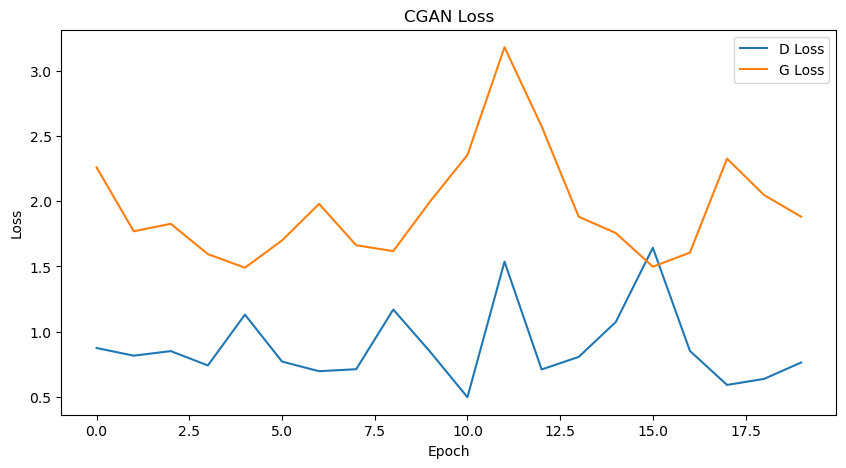

In [136]:
# evaluate
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = c_discriminator(imgs, labels)
        predicted = (outputs > 0.5).float()
        total += imgs.size(0)
        correct += (predicted == torch.ones_like(predicted, device=device)).sum().item()
print(f"CGAN Accuracy: {100 * correct / total}%")

# plot c_gan loss(d_loss, g_loss)
plt.figure(figsize=(10, 5))
plt.title('CGAN Loss')
plt.plot(c_d_loss, label='D Loss')
plt.plot(c_g_loss, label='G Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./images/CGAN_loss.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


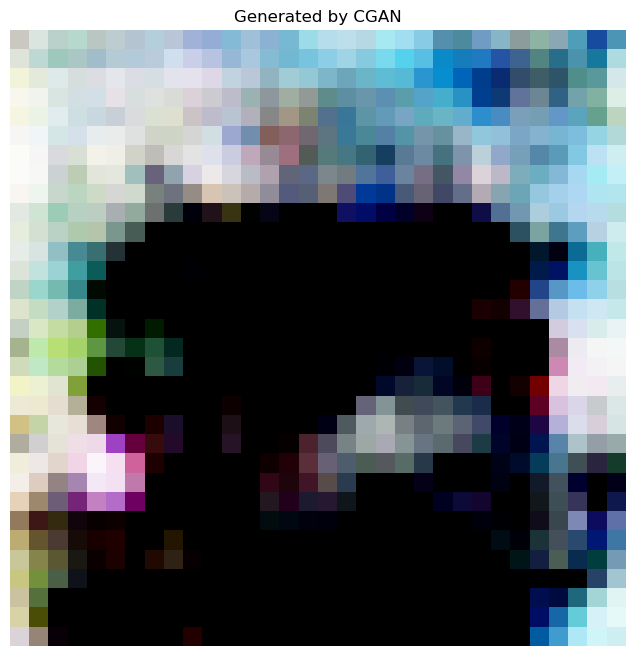

In [121]:
# 保存生成图形（CGAN）
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    labels = torch.arange(10).repeat(7).to(device)[:64]  # 每个类别生成 6 张图片，截取前 64 个标签
    samples = c_generator(z, labels).cpu()
    save_image(samples, './images/cgan_samples.png', nrow=10, normalize=True)
    
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated by CGAN")
    plt.imshow(np.transpose(samples[0], (1, 2, 0)))
    plt.show()


# GAN 与 CGAN 生成图像的对比

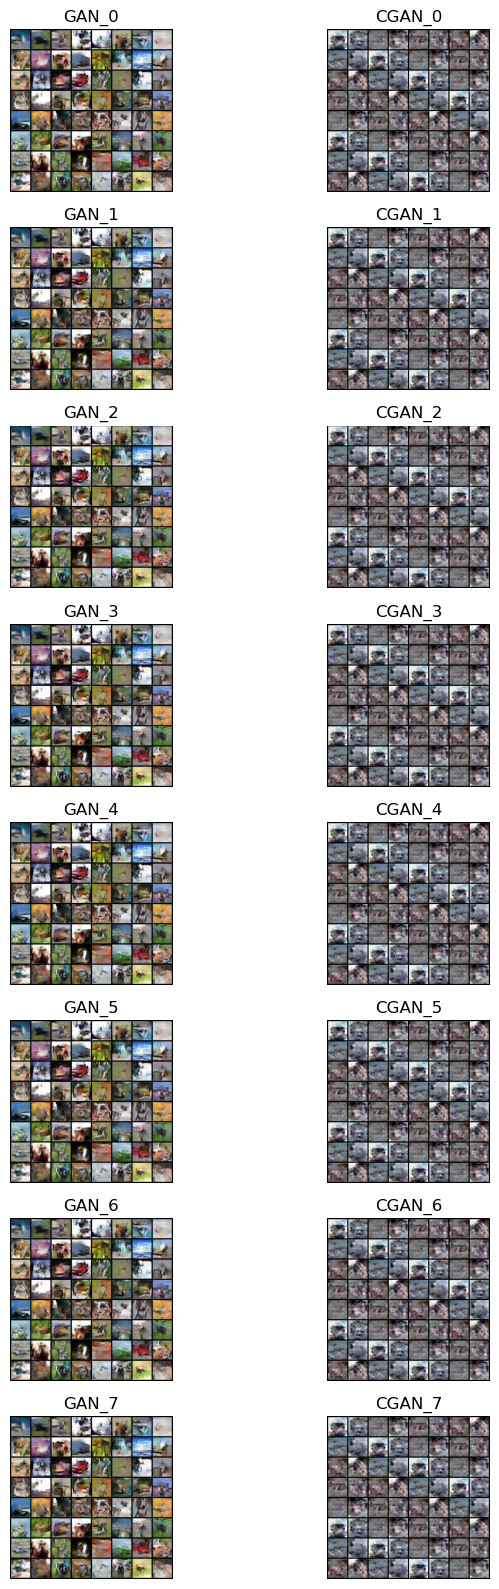

In [123]:
# 展示GAN与CGAN生成的对比图像

# GAN 生成的图像
with torch.no_grad():
    z_gan = torch.randn(64, latent_dim, device=device)
    samples_gan = generator(z_gan).cpu()  # 假设使用的是基础GAN的生成器
    samples_gan = (samples_gan + 1) / 2  # 将 [-1, 1] 转换到 [0, 1]

# CGAN 生成的图像
with torch.no_grad():
    z_cgan = torch.randn(64, latent_dim, device=device)
    labels_cgan = torch.arange(10).repeat(7).to(device)  # 每个类别生成 6 张图片
    samples_cgan = c_generator(z_cgan, labels_cgan[:64]).cpu()
    samples_cgan = (samples_cgan + 1) / 2  # 将 [-1, 1] 转换到 [0, 1]

# 可视化
fig, axes = plt.subplots(8, 2, figsize=(8, 16))
samples_gan = make_grid(samples_gan, nrow=8).permute(1, 2, 0).numpy()
samples_cgan = make_grid(samples_cgan, nrow=8).permute(1, 2, 0).numpy()

for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.imshow(samples_gan)
        ax.set_title(f"GAN_{int((i+1)/2)}")
    else:
        ax.imshow(samples_cgan)
        ax.set_title(f"CGAN_{int((i-1)/2)}")
    ax.axis("off")

plt.tight_layout()
plt.show()
